### Load packages

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import os
print(os.listdir("../input"))

import warnings
warnings.filterwarnings('ignore')

# Any results you write to the current directory are saved as output.

['my-ocean-ml-dataset']


### Load data

In [5]:
train = pd.read_csv('/kaggle/input/my-ocean-ml-dataset/train.csv')
test = pd.read_csv('/kaggle/input/my-ocean-ml-dataset/test1.csv')
#Semi supervised learning
# top_sub = pd.read_csv('/kaggle/input/oceam-ml-top-submission-66/submission18(added kernel regression).csv')
# semi_train = test
# semi_train['WVHT(m)']= top_sub['WVHT(m)']
# train = train.append(semi_train)
print ("Data is loaded!")

Data is loaded!


In [6]:
print ("Train: ",train.shape[0],"sales, and ",train.shape[1],"features")
print ("Test: ",test.shape[0],"sales, and ",test.shape[1],"features")

Train:  3886 sales, and  17 features
Test:  1535 sales, and  16 features


In [7]:
train.head()

,ID,#YY,MM,DD,hh,mm,WDIR(degT),WSPD(m/s),GST(m/s),DPD(sec),APD(sec),MWD(degT),PRES(hPa),ATMP(degC),WTMP(degC),DEWP(degC),WVHT(m)
0,2017424150,2017,4,24,1,50,23,3.0,3.6,4.17,3.33,349,1019.1,4.7,5.1,4.2,0.39
1,2017424250,2017,4,24,2,50,30,2.9,3.3,5.26,4.21,358,1018.8,4.6,4.8,4.1,0.65
2,2017424350,2017,4,24,3,50,360,2.2,2.5,5.88,4.79,11,1018.3,4.6,4.7,4.2,0.90
3,2017424450,2017,4,24,4,50,355,2.5,3.1,5.88,4.95,23,1018.1,4.6,4.6,4.2,0.91
4,2017424550,2017,4,24,5,50,355,3.5,4.5,6.25,4.98,26,1018.3,4.5,4.6,4.0,0.88


In [8]:
test.head()

,ID,#YY,MM,DD,hh,mm,WDIR(degT),WSPD(m/s),GST(m/s),DPD(sec),APD(sec),MWD(degT),PRES(hPa),ATMP(degC),WTMP(degC),DEWP(degC)
0,2019722240,2019,7,2,22,40,340,6.7,8.2,2.35,2.37,177,1011.5,18.6,16.8,17.8
1,2019722340,2019,7,2,23,40,15,2.3,5.5,2.60,2.44,336,1010.7,19.0,16.9,17.8
2,201973140,2019,7,3,1,40,11,1.6,2.7,3.13,2.95,341,1010.6,17.9,16.7,17.3
3,2019761040,2019,7,6,10,40,21,4.1,4.9,2.86,2.59,8,1015.8,20.0,20.3,19.5
4,2019761140,2019,7,6,11,40,16,4.5,5.4,2.74,2.64,16,1016.5,20.1,20.3,19.6


# EDA

In [9]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('WVHT(m)')
quantitative.remove('ID')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [10]:
quantitative

['#YY',
 'MM',
 'DD',
 'hh',
 'mm',
 'WDIR(degT)',
 'WSPD(m/s)',
 'GST(m/s)',
 'DPD(sec)',
 'APD(sec)',
 'MWD(degT)',
 'PRES(hPa)',
 'ATMP(degC)',
 'WTMP(degC)',
 'DEWP(degC)']

In [11]:
qualitative

[]

In [12]:
# sns.set_style("whitegrID")
# missing = train.isnull().sum()
# missing = missing[missing > 0]
# missing.sort_values(inplace=True)
# missing.plot.bar()

19 attributes have missing values, 5 over 50% of all data. Most of times NA means lack of subject described by attribute, like missing pool, fence, no garage and basement.

<AxesSubplot:title={'center':'Log Normal'}, xlabel='WVHT(m)'>

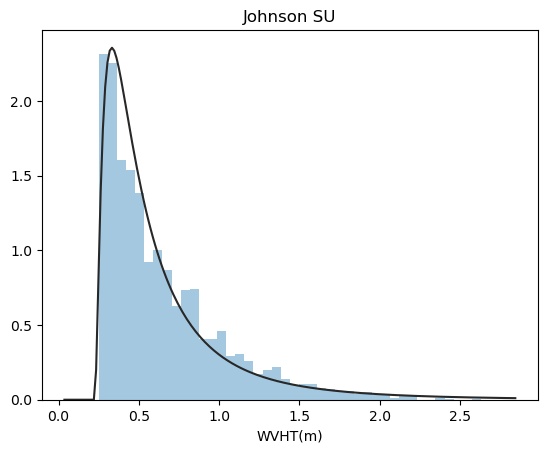

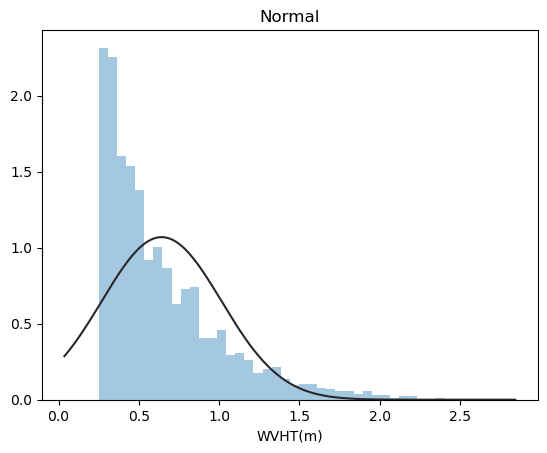

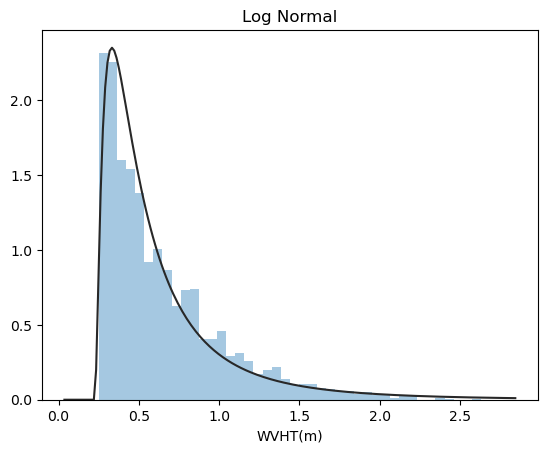

In [13]:
y = train['WVHT(m)']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

It is apparent that WVHT(m) doesn't follow normal distribution, so before performing regression it has to be transformed. While log transformation does pretty good job, best fit is unbounded Johnson distribution.

In [14]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


Also none of quantitative variables has normal distribution so these should be transformed as well.

**Spearman correlation** is better to work with in this case because it picks up relationships between variables even when they are nonlinear. OverallQual is main criterion in establishing house price. Neighborhood has big influence, partially it has some intrisinc value in itself, but also houses in certain regions tend to share same characteristics (confunding) what causes similar valuations.

In [15]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'WVHT(m)']].groupby(feature).mean()['WVHT(m)']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

[]


In [16]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['WVHT(m)'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
#spearman(train, features)

<AxesSubplot:>

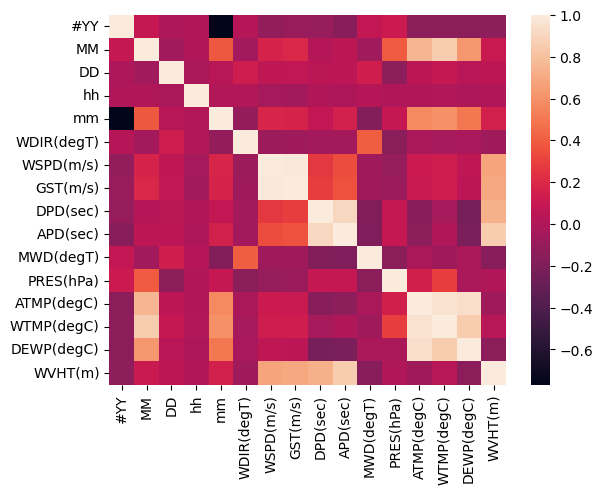

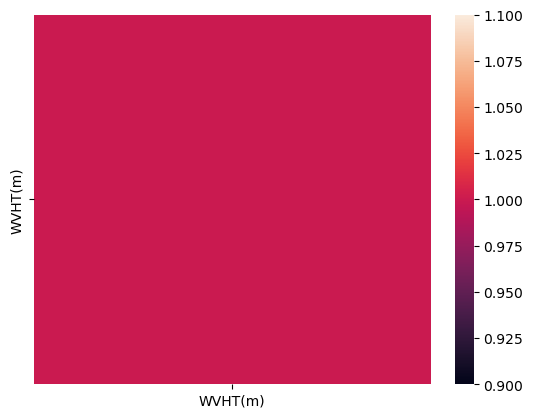

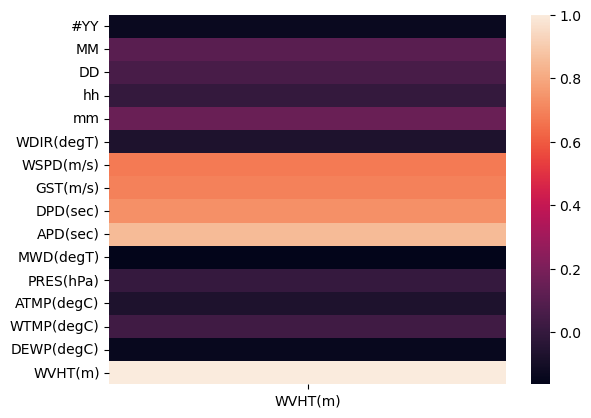

In [17]:
plt.figure(1)
corr = train[quantitative+['WVHT(m)']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = train[qual_encoded+['WVHT(m)']].corr()
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['WVHT(m)'], columns=qual_encoded+['WVHT(m)'])
for q1 in quantitative+['WVHT(m)']:
    for q2 in qual_encoded+['WVHT(m)']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)

### Simple clustering

In [18]:
features = quantitative + qual_encoded
# model = TSNE(n_components=2, random_state=0, perplexity=50)
# X = train[features].fillna(0.).values
# tsne = model.fit_transform(X)

# std = StandardScaler()
# s = std.fit_transform(X)
# pca = PCA(n_components=10)
# pca.fit(s)
# pc = pca.transform(s)
# kmeans = KMeans(n_clusters=5)
# kmeans.fit(pc)

# fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
# sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
# print(np.sum(pca.explained_variance_ratio_))

# Models

### Data processing

In [19]:
train.drop(['ID'], axis=1, inplace=True)
test.drop(['ID'], axis=1, inplace=True)

In [20]:
#train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)
#train["WVHT(m)"] = np.log1p(train["WVHT(m)"])
y = train['WVHT(m)'].reset_index(drop=True)
y = np.log1p(y)

### Features

In [21]:
train_features = train.drop(['WVHT(m)'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

In [22]:
features.shape

(5421, 15)

In [23]:
# features['MSSubClass'] = features['MSSubClass'].apply(str)
# features['YrSold'] = features['YrSold'].astype(str)
# features['MoSold'] = features['MoSold'].astype(str)
# features['Functional'] = features['Functional'].fillna('Typ') 
# features['Electrical'] = features['Electrical'].fillna("SBrkr") 
# features['KitchenQual'] = features['KitchenQual'].fillna("TA") 
# features["PoolQC"] = features["PoolQC"].fillna("None")
# features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
# features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
# features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])


In [24]:
features.head()

,#YY,MM,DD,hh,mm,WDIR(degT),WSPD(m/s),GST(m/s),DPD(sec),APD(sec),MWD(degT),PRES(hPa),ATMP(degC),WTMP(degC),DEWP(degC)
0,2017,4,24,1,50,23,3.0,3.6,4.17,3.33,349,1019.1,4.7,5.1,4.2
1,2017,4,24,2,50,30,2.9,3.3,5.26,4.21,358,1018.8,4.6,4.8,4.1
2,2017,4,24,3,50,360,2.2,2.5,5.88,4.79,11,1018.3,4.6,4.7,4.2
3,2017,4,24,4,50,355,2.5,3.1,5.88,4.95,23,1018.1,4.6,4.6,4.2
4,2017,4,24,5,50,355,3.5,4.5,6.25,4.98,26,1018.3,4.5,4.6,4.0


In [25]:
# for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
#     features[col] = features[col].fillna(0)

# for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
#     features[col] = features[col].fillna('None')

# for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
#     features[col] = features[col].fillna('None')

# features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [26]:
# features.head()

In [27]:
# objects = []
# for i in features.columns:
#     if features[i].dtype == object:
#         objects.append(i)
# #features.update(features[objects].fillna('None'))

# #features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# numerics = []
# for i in features.columns:
#     if features[i].dtype in numeric_dtypes:
#         numerics.append(i)
# #features.update(features[numerics].fillna(0))

In [28]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

In [29]:
# features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

# features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
# features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

# features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
#                                  features['1stFlrSF'] + features['2ndFlrSF'])

# features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
#                                features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

# features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
#                               features['EnclosedPorch'] + features['ScreenPorch'] +
#                               features['WoodDeckSF'])


In [30]:
features.head()

,#YY,MM,DD,hh,mm,WDIR(degT),WSPD(m/s),GST(m/s),DPD(sec),APD(sec),MWD(degT),PRES(hPa),ATMP(degC),WTMP(degC),DEWP(degC)
0,2017,4,24,1,50,23,3.0,3.6,1.093755,0.673352,349,1019.1,4.7,5.1,4.2
1,2017,4,24,2,50,30,2.9,3.3,1.169382,0.699965,358,1018.8,4.6,4.8,4.1
2,2017,4,24,3,50,360,2.2,2.5,1.203962,0.712615,11,1018.3,4.6,4.7,4.2
3,2017,4,24,4,50,355,2.5,3.1,1.203962,0.715621,23,1018.1,4.6,4.6,4.2
4,2017,4,24,5,50,355,3.5,4.5,1.222403,0.716164,26,1018.3,4.5,4.6,4.0


In [31]:
import numpy as np



# # Generate statistical features
# for col in features.columns:
#     if col != 'WVHT(m)':
#         features[col + '_mean'] = features[col].mean()
#         features[col + '_std'] = (features[col]+1e-5).std()
#         features[col + '_max'] = features[col].max()
#         features[col + '_min'] = features[col].min()
#         features[col + '_median'] = features[col].median()
#         features[col + '_range'] = features[col + '_max'] - features[col + '_min']
# # Generate polynomial features
# for col in features.columns:
#     if col != 'WVHT(m)':
#         for degree in range(2, 4):
#             feat_name = col + '^' + str(degree)
#             features[feat_name] = features[col] ** degree
# # Generate log features
# for col in features.columns:
#     if col != 'WVHT(m)':
#         features[col + '_log'] = np.log(features[col]+1e-5)

import pandas as pd
import numpy as np
# Assuming features is a pandas DataFrame with the features
window_size = 12  # in hours
# Define the columns to create rolling features for
rolling_cols = ['WDIR(degT)', 'WSPD(m/s)', 'GST(m/s)', 'DPD(sec)', 'APD(sec)', 'PRES(hPa)', 'ATMP(degC)', 'WTMP(degC)', 'DEWP(degC)']
# Create rolling averages for each column
for col in rolling_cols:
    features[f'{col}_rolling_mean_{window_size}h'] = features[col].rolling(window_size, min_periods=1).mean()
    
# # Create rolling standard deviations for each column
# for col in rolling_cols:
#     features[f'{col}_rolling_std_{window_size}h'] = features[col].rolling(window_size, min_periods=1).std()
    
# # Create rolling minimums for each column
# for col in rolling_cols:
#     features[f'{col}_rolling_min_{window_size}h'] = features[col].rolling(window_size, min_periods=1).min()
    
# # Create rolling maximums for each column
# for col in rolling_cols:
#     features[f'{col}_rolling_max_{window_size}h'] = features[col].rolling(window_size, min_periods=1).max()
# Create rolling percentiles for each column
for col in rolling_cols:
    for pct in [0.25, 0.5, 0.75]:
        features[f'{col}_rolling_pct_{pct}_{window_size}h'] = features[col].rolling(window_size, min_periods=1).quantile(pct)

# Add hour-of-day features
features['hour_sin'] = np.sin(2*np.pi*features['hh']/24)
features['hour_cos'] = np.cos(2*np.pi*features['hh']/24)
#features = features.drop('hh', axis=1)

# Add wind direction feature
features['WDIR_sin'] = np.sin(2*np.pi*features['WDIR(degT)']/360)
features['WDIR_cos'] = np.cos(2*np.pi*features['WDIR(degT)']/360)
#features = features.drop('WDIR(degT)', axis=1)

# Add wave direction feature
features['MWD_sin'] = np.sin(2*np.pi*features['MWD(degT)']/360)
features['MWD_cos'] = np.cos(2*np.pi*features['MWD(degT)']/360)
#features = features.drop('MWD(degT)', axis=1)

# Add temperature difference feature
features['temp_diff'] = features['ATMP(degC)'] - features['WTMP(degC)']
#features = features.drop(['ATMP(degC)', 'WTMP(degC)'], axis=1)

# Add pressure difference feature
features['pres_diff'] = features['PRES(hPa)'].diff()
features['pres_diff'].iloc[0] = 0
#features = features.drop('PRES(hPa)', axis=1)

# Add rolling mean feature
features['WSPD(m/s)_rolling_mean'] = features['WSPD(m/s)'].rolling(window=3, min_periods=1).mean()

# Add interaction features
features['WSPD_WDIR_interaction'] = features['WSPD(m/s)'] * features['WDIR_sin']
features['DPD_MWD_interaction'] = features['DPD(sec)'] * features['MWD_sin']
features['temp_pres_interaction'] = features['temp_diff'] * features['pres_diff']
features['WSPD_pres_interaction'] = features['WSPD(m/s)'] * features['pres_diff']
features['APD_WDIR_interaction'] = features['APD(sec)'] * features['WDIR_sin']
features['WSPD_DPD_interaction'] = features['WSPD(m/s)'] * features['DPD(sec)']


# Define more interaction features
features['WSPD_WDIR_interaction'] = features['WSPD(m/s)'] * np.sin(features['WDIR(degT)'])
features['DPD_MWD_interaction'] = features['DPD(sec)'] * np.sin(features['MWD(degT)'])
features['temp_pres_interaction'] = features['ATMP(degC)'] * features['PRES(hPa)']
features['WSPD_pres_interaction'] = features['WSPD(m/s)'] * features['PRES(hPa)']
features['APD_WDIR_interaction'] = features['APD(sec)'] * np.sin(features['WDIR(degT)'])
features['WSPD_DPD_interaction'] = features['WSPD(m/s)'] * features['DPD(sec)']
features['WDIR_PRES_interaction'] = np.sin(features['WDIR(degT)']) * features['PRES(hPa)']
features['WSPD_DirDev_interaction'] = features['WSPD(m/s)'] * np.sin(np.abs(features['WDIR(degT)'] - features['MWD(degT)']))
features['ATMP_WDIR_interaction'] = features['ATMP(degC)'] * np.sin(features['WDIR(degT)'])
features['WSPD_MWD_interaction'] = features['WSPD(m/s)'] * np.sin(features['MWD(degT)'])
features['DPD_WDIR_interaction'] = features['DPD(sec)'] * np.sin(features['WDIR(degT)'])
features['APD_PRES_interaction'] = features['APD(sec)'] * features['PRES(hPa)']
features['ATMP_DPD_interaction'] = features['ATMP(degC)'] * features['DPD(sec)']
features['WDIR_DirDev_interaction'] = np.sin(features['WDIR(degT)']) * np.sin(np.abs(features['WDIR(degT)'] - features['MWD(degT)']))
features['WSPD_ATMP_interaction'] = features['WSPD(m/s)'] * features['ATMP(degC)']
features['MWD_PRES_interaction'] = np.sin(features['MWD(degT)']) * features['PRES(hPa)']
features['DPD_PRES2_interaction'] = features['DPD(sec)'] * features['PRES(hPa)']**2
features['WSPD_WDIR2_interaction'] = features['WSPD(m/s)'] * np.sin(features['WDIR(degT)'])**2
features['APD_ATMP_interaction'] = features['APD(sec)'] * features['ATMP(degC)']
features['WDIR_temp_interaction'] = np.sin(features['WDIR(degT)']) * features['ATMP(degC)']
features['WSPD_PRES2_interaction'] = features['WSPD(m/s)'] * features['PRES(hPa)']**2
features['MWD_temp_interaction'] = np.sin(features['MWD(degT)']) * features['ATMP(degC)']
features['WSPD_DirDev2_interaction'] = features['WSPD(m/s)'] * np.sin(np.abs(features['WDIR(degT)'] - features['MWD(degT)']))**2
features['DPD_ATMP_interaction'] = features['DPD(sec)'] * features['ATMP(degC)']

                                             
# Compute wave height from period
features['wave_height_from_period'] = (features['DPD(sec)'] * 9.81) / (2 * np.pi)
# Compute wave speed and wavelength assuming water depth of 50m
features['wave_speed'] = 1.56 * (features['DPD(sec)']**0.5)
features['wavelength'] = features['wave_speed'] * features['DPD(sec)']

# Compute wave steepness
g = 9.81
features['wavelength1'] = features['APD(sec)']**2 * g / (2 * np.pi)
features['wave_steepness'] = features['wave_height_from_period'] / features['wavelength1']

# Compute u and v components of wind speed
features['u_wind'] = -features['WSPD(m/s)'] * np.sin(features['WDIR(degT)'] * np.pi / 180)
features['v_wind'] = -features['WSPD(m/s)'] * np.cos(features['WDIR(degT)'] * np.pi / 180)
# Compute wave power
rho = 1025
g = 9.81
features['wave_power_dpd'] = 0.5 * rho * g * features['wave_height_from_period']**2 * features['DPD(sec)']
features['wave_power_apd'] = 0.5 * rho * g * features['wave_height_from_period']**2 * features['APD(sec)']

# compute wave age
features['wave_age'] = features['APD(sec)']/((features['WSPD(m/s)']+1e-4)/0.71)

#Compute wave energy
features['wave_energy'] = 0.5*rho*g*features['wave_height_from_period']**2



# Add day-of-week features
features.update(features.fillna(0))

In [32]:
# features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
# features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
# features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
# features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
# features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [33]:
features.shape

(5421, 95)

In [34]:
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(5421, 95)

In [35]:
final_features.head()

,#YY,MM,DD,hh,mm,WDIR(degT),WSPD(m/s),GST(m/s),DPD(sec),APD(sec),...,wave_speed,wavelength,wavelength1,wave_steepness,u_wind,v_wind,wave_power_dpd,wave_power_apd,wave_age,wave_energy
0,2017,4,24,1,50,23,3.0,3.6,1.093755,0.673352,...,1.631490,1.784450,0.707902,2.412326,-1.172193e+00,-2.761515,16036.175947,9872.402925,0.159355,14661.585144
1,2017,4,24,2,50,30,2.9,3.3,1.169382,0.699965,...,1.686953,1.972693,0.764965,2.386734,-1.450000e+00,-2.511474,19597.958275,11730.878089,0.171365,16759.238092
2,2017,4,24,3,50,360,2.2,2.5,1.203962,0.712615,...,1.711713,2.060837,0.792865,2.370841,5.388446e-16,-2.200000,21388.448397,12659.650589,0.229970,17765.055634
3,2017,4,24,4,50,355,2.5,3.1,1.203962,0.715621,...,1.711713,2.060837,0.799567,2.350968,2.178894e-01,-2.490487,21388.448397,12713.044105,0.203228,17765.055634
4,2017,4,24,5,50,355,3.5,4.5,1.222403,0.716164,...,1.724773,2.108368,0.800782,2.383358,3.050451e-01,-3.486681,22386.427379,13115.441576,0.145275,18313.453306


In [36]:
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]
X.shape, y.shape, X_sub.shape

((3886, 95), (3886,), (1535, 95))

In [37]:
# import numpy as np

# # assume X and y are defined as in the problem statement

# # calculate the mean and standard deviation of each column of X
# col_means = np.mean(X, axis=0)
# col_stds = np.std(X, axis=0)

# # identify the indices of rows with at least one outlier column
# outliers = np.where((X > col_means + 3*col_stds) | (X < col_means - 3*col_stds))[0]

# # define a boolean array indicating which rows are outliers
# outliers_bool = np.zeros(X.shape[0], dtype=bool)
# outliers_bool[outliers] = True

# # remove the outliers from the dataset and corresponding labels
# X_clean = X[~outliers_bool]
# y_clean = y[~outliers_bool]



# X,y=X_clean,y_clean

In [38]:
# outliers = [30, 88, 462, 631, 1322]
# X = X.drop(X.index[outliers])
# y = y.drop(y.index[outliers])

# overfit = []
# for i in X.columns:
#     counts = X[i].value_counts()
#     zeros = counts.iloc[0]
#     if zeros / len(X) * 100 > 99.94:
#         overfit.append(i)

# overfit = list(overfit)
# X = X.drop(overfit, axis=1)
# X_sub = X_sub.drop(overfit, axis=1)

In [39]:
X.shape, y.shape, X_sub.shape

((3886, 95), (3886,), (1535, 95))

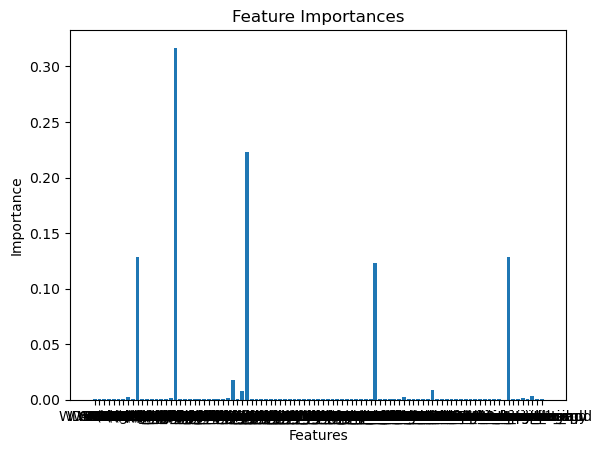

                          feature  importance
0       GST(m/s)_rolling_mean_12h    0.317013
1   GST(m/s)_rolling_pct_0.75_12h    0.222708
2                     wavelength1    0.128779
3                        APD(sec)    0.128527
4          WSPD(m/s)_rolling_mean    0.123182
..                            ...         ...
90                 wave_power_dpd    0.000101
91        wave_height_from_period    0.000099
92                             mm    0.000092
93                    wave_energy    0.000082
94                     wavelength    0.000072

[95 rows x 2 columns]


In [40]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_regressor.fit(X, y)

# Print the feature importance
importance = rf_regressor.feature_importances_

import matplotlib.pyplot as plt

# Get the feature names
feature_names = list(features.columns)

# Plot the feature importances
plt.bar(feature_names, importance)
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

import pandas as pd

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importance})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop=True)

# Print the sorted table
print(feature_importances)



In [41]:
imp_feats = list(feature_importances['feature'][:20])

In [42]:
imp_final_features = final_features[imp_feats]

In [43]:
# X = imp_final_features.iloc[:len(y), :]
# X_sub = final_features.iloc[len(y):, :]
# X.shape, y.shape, X_sub.shape

In [44]:
# from keras.models import Sequential
# from keras.layers import Dense, BatchNormalization, Dropout
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import StandardScaler
# import numpy as np

# # Define the neural network architecture
# # Define the neural network architecture
# def build_model():
#     model = Sequential()
#     model.add(Dense(1024, input_dim=59, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.2))
#     model.add(Dense(512, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.2))
#     model.add(Dense(128, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.1))
#     model.add(Dense(64, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.1))
#     model.add(Dense(1, activation='linear'))
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     return model

# # Initialize the scaler and normalize the training and test data
# scaler = StandardScaler()
# X_norm = scaler.fit_transform(X)
# X_sub_norm = scaler.transform(X_sub)

# # Initialize the KFold cross-validation
# n_splits = 10
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Initialize an empty list to store the predictions and RMSE values
# predictions = []
# rmse_values = []

# # Loop over the KFold splits
# for fold, (train_index, val_index) in enumerate(kf.split(X_norm), 1):
#     print(f"Fold {fold}:")

#     # Split the data into training and validation sets
#     X_train, y_train = X_norm[train_index], y[train_index]
#     X_val, y_val = X_norm[val_index], y[val_index]

#     # Build the neural network
#     model = build_model()

#     # Define the callbacks
#     early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
#     lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', min_lr=1e-6)

#     # Train the neural network on the training data
#     history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stop, lr_schedule])

#     # Compute the RMSE for the validation set
#     y_pred = model.predict(X_val)
#     rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#     rmse_values.append(rmse)

#     # Print the RMSE for the current fold
#     print(f"  RMSE: {rmse:.4f}")

#     # Use the neural network to make predictions on the test data
#     prediction = model.predict(X_sub_norm)

#     # Add the predictions to the list of predictions
#     predictions.append(prediction)

# # Compute the final predictions as the average of the KFold predictions
# final_predictions = np.mean(predictions, axis=0)

# # Compute the mean RMSE across all folds
# mean_rmse = np.mean(rmse_values)
# print(f"Mean RMSE: {mean_rmse:.4f}")


In [45]:
#final_predictions.reshape((final_predictions.shape[0],)).shape

In [46]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [47]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [48]:
rIDge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))



from sklearn.kernel_ridge import KernelRidge

kernel_reg = make_pipeline(RobustScaler(), KernelRidge(alpha=1.0, kernel='linear', degree=3, gamma=None, coef0=1, kernel_params=None))


In [49]:
rf = RandomForestRegressor(n_estimators=25500, random_state=44)

In [50]:
gbr = GradientBoostingRegressor(n_estimators=25500, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =44)                             

In [51]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=25500,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [52]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=25500,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [53]:
# stack_gen = StackingCVRegressor(regressors= (rIDge, lasso, elasticnet, gbr, xgboost, lightgbm),
#                                 meta_regressor=xgboost,
#                                 use_features_in_secondary=True)

In [54]:
from catboost import CatBoostRegressor

In [55]:
cboost = CatBoostRegressor(
    iterations=10000,  # maximum number of trees to build
    learning_rate=0.1,  # learning rate for gradient boosting
    depth=6,  # maximum depth of each tree
    l2_leaf_reg=1,  # L2 regularization coefficient
    random_seed=42,  # random seed for reproducibility
    verbose = False
)


In [56]:
stack_gen = StackingCVRegressor(regressors= (rIDge, lasso, elasticnet,kernel_reg,cboost, gbr, xgboost, lightgbm,rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [57]:
# score = cv_rmse(cboost)
# print("cboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# # score = cv_rmse(rIDge)
# # print("ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# # score = cv_rmse(lasso)
# # print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# # score = cv_rmse(elasticnet)
# # print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(svr)
# print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(lightgbm)
# print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(gbr)
# print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(xgboost)
# print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

In [58]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)



print('kernel_reg')
kernel_reg_full_data = kernel_reg.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('RIDge')
rIDge_model_full_data = rIDge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

print('catboost')
cboost_model_full_data = cboost.fit(X, y)

print('catboost')
rf_model_full_data = rf.fit(X, y)

START Fit
stack_gen


KeyboardInterrupt: 

# Blending Models

In [ ]:
def blend_models_predict(X):
    #final_predictions = model.predict(X)
    return ((0.03 * elastic_model_full_data.predict(X)) + \
            (0.03 * lasso_model_full_data.predict(X)) + \
            (0.04 * kernel_reg_full_data.predict(X)) + \
            (0.04 * rIDge_model_full_data.predict(X)) + \
            (0.04 * svr_model_full_data.predict(X)) + \
            (0.13 * gbr_model_full_data.predict(X)) + \
            (0.13 * xgb_model_full_data.predict(X)) + \
            (0.13 * lgb_model_full_data.predict(X)) + \
            (0.13 * cboost_model_full_data.predict(X))+ \
            (0.10 * cboost_model_full_data.predict(X))+ \
            #(0.4 * final_predictions.reshape((final_predictions.shape[0],)))+\
            (0.20 * stack_gen_model.predict(np.array(X))))

In [ ]:
# def blend_models_predict(X):
#     return ((0.20 * cboost_model_full_data.predict(X)) + \
#             (0.05 * svr_model_full_data.predict(X)) + \
#             (0.15 * gbr_model_full_data.predict(X)) + \
#             (0.15 * xgb_model_full_data.predict(X)) + \
#             (0.15 * lgb_model_full_data.predict(X)) + \
#             (0.30 * stack_gen_model.predict(np.array(X))))

In [ ]:
print('RMSLE score on train data:')
print(rmsle(np.expm1(y), np.expm1(blend_models_predict(X))))

In [ ]:
blend_models_predict(X)[:2]

In [ ]:
print('Predict submission')
submission = pd.read_csv("/kaggle/input/my-ocean-ml-dataset/sample2.csv")
submission.iloc[:,1] = np.expm1(blend_models_predict(X_sub)) #np.expm1(blend_models_predict(X_sub))

In [ ]:
# print('Blend with Top Kernels submissions\n')
# sub_1 = pd.read_csv('../input/top-10-0-10943-stacking-mice-and-brutal-force/House_Prices_submit.csv')
# sub_2 = pd.read_csv('../input/hybrID-svm-benchmark-approach-0-11180-lb-top-2/hybrID_solution.csv')
# sub_3 = pd.read_csv('../input/lasso-model-for-regression-problem/lasso_sol22_Median.csv')
# submission.iloc[:,1] = np.floor((0.25 * np.floor(np.expm1(blend_models_predict(X_sub)))) + 
#                                 (0.25 * sub_1.iloc[:,1]) + 
#                                 (0.25 * sub_2.iloc[:,1]) + 
#                                 (0.25 * sub_3.iloc[:,1]))

# Submission

In [ ]:
# q1 = submission['WVHT(m)'].quantile(0.005)
# q2 = submission['WVHT(m)'].quantile(0.995)
# submission['WVHT(m)'] = submission['WVHT(m)'].apply(lambda x: x if x > q1 else x*0.77)
# submission['WVHT(m)'] = submission['WVHT(m)'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission28(best+log1p transform).csv", index=False)

In [ ]:
submission.head()

# New blending

Based on: **https://www.kaggle.com/itslek/blend-stack-lr-gb-0-10649-house-prices-v57/data?scriptVersionID=11189608**

In [ ]:
# from datetime import datetime

# from scipy.stats import skew  # for some statistics
# from scipy.special import boxcox1p
# from scipy.stats import boxcox_normmax

# from sklearn.linear_model import ElasticNetCV, LassoCV, RIDgeCV
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.svm import SVR
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import RobustScaler
# from sklearn.model_selection import KFold, cross_val_score
# from sklearn.metrics import mean_squared_error
# from mlxtend.regressor import StackingCVRegressor


In [ ]:
# # Based on https://www.kaggle.com/hemingwei/top-2-from-laurenstc-on-house-price-prediction

# train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
# test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
# print("Train set size:", train.shape)
# print("Test set size:", test.shape)
# print('START data processing', datetime.now(), )

# train_ID = train['ID']
# test_ID = test['ID']
# # Now drop the  'ID' colum since it's unnecessary for  the prediction process.
# train.drop(['ID'], axis=1, inplace=True)
# test.drop(['ID'], axis=1, inplace=True)

# # Deleting outliers
# train = train[train.GrLivArea < 4500]
# train.reset_index(drop=True, inplace=True)

# # We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
# train["WVHT(m)"] = np.log1p(train["WVHT(m)"])
# y = train.WVHT(m).reset_index(drop=True)
# train_features = train.drop(['WVHT(m)'], axis=1)
# test_features = test

# features = pd.concat([train_features, test_features]).reset_index(drop=True)
# print(features.shape)
# # Some of the non-numeric predictors are stored as numbers; we convert them into strings 
# features['MSSubClass'] = features['MSSubClass'].apply(str)
# features['YrSold'] = features['YrSold'].astype(str)
# features['MoSold'] = features['MoSold'].astype(str)

# features['Functional'] = features['Functional'].fillna('Typ')
# features['Electrical'] = features['Electrical'].fillna("SBrkr")
# features['KitchenQual'] = features['KitchenQual'].fillna("TA")
# features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
# features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
# features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

# features["PoolQC"] = features["PoolQC"].fillna("None")

# for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
#     features[col] = features[col].fillna(0)
# for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
#     features[col] = features[col].fillna('None')
# for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
#     features[col] = features[col].fillna('None')

# features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# objects = []
# for i in features.columns:
#     if features[i].dtype == object:
#         objects.append(i)

# features.update(features[objects].fillna('None'))

# features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# # Filling in the rest of the NA's

# numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# numerics = []
# for i in features.columns:
#     if features[i].dtype in numeric_dtypes:
#         numerics.append(i)
# features.update(features[numerics].fillna(0))

# numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# numerics2 = []
# for i in features.columns:
#     if features[i].dtype in numeric_dtypes:
#         numerics2.append(i)

# skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

# high_skew = skew_features[skew_features > 0.5]
# skew_index = high_skew.index

# for i in skew_index:
#     features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

# features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

# features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
# features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

# features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
#                                  features['1stFlrSF'] + features['2ndFlrSF'])

# features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
#                                features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

# features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
#                               features['EnclosedPorch'] + features['ScreenPorch'] +
#                               features['WoodDeckSF'])

# # simplified features
# features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
# features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
# features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
# features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
# features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# print(features.shape)
# final_features = pd.get_dummies(features).reset_index(drop=True)
# print(final_features.shape)

# X = final_features.iloc[:len(y), :]
# X_sub = final_features.iloc[len(X):, :]

# print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

# outliers = [30, 88, 462, 631, 1322]
# X = X.drop(X.index[outliers])
# y = y.drop(y.index[outliers])

# overfit = []
# for i in X.columns:
#     counts = X[i].value_counts()
#     zeros = counts.iloc[0]
#     if zeros / len(X) * 100 > 99.94:
#         overfit.append(i)

# overfit = list(overfit)
# overfit.append('MSZoning_C (all)')

# X = X.drop(overfit, axis=1).copy()
# X_sub = X_sub.drop(overfit, axis=1).copy()

# print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

# # ################## ML ########################################
# print('START ML', datetime.now(), )

# kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


# # rmsle
# def rmsle(y, y_pred):
#     return np.sqrt(mean_squared_error(y, y_pred))


# # build our model scoring function
# def cv_rmse(model, X=X):
#     rmse = np.sqrt(-cross_val_score(model, X, y,
#                                     scoring="neg_mean_squared_error",
#                                     cv=kfolds))
#     return (rmse)


# # setup models    
# alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
# alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
# e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
# e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

# rIDge = make_pipeline(RobustScaler(),
#                       RIDgeCV(alphas=alphas_alt, cv=kfolds))

# lasso = make_pipeline(RobustScaler(),
#                       LassoCV(max_iter=1e7, alphas=alphas2,
#                               random_state=42, cv=kfolds))

# elasticnet = make_pipeline(RobustScaler(),
#                            ElasticNetCV(max_iter=1e7, alphas=e_alphas,
#                                         cv=kfolds, l1_ratio=e_l1ratio))
                                        
# svr = make_pipeline(RobustScaler(),
#                       SVR(C= 20, epsilon= 0.008, gamma=0.0003,))


# gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
#                                    max_depth=4, max_features='sqrt',
#                                    min_samples_leaf=15, min_samples_split=10, 
#                                    loss='huber', random_state =42)
                                   

# lightgbm = LGBMRegressor(objective='regression', 
#                                        num_leaves=4,
#                                        learning_rate=0.01, 
#                                        n_estimators=5000,
#                                        max_bin=200, 
#                                        bagging_fraction=0.75,
#                                        bagging_freq=5, 
#                                        bagging_seed=7,
#                                        feature_fraction=0.2,
#                                        feature_fraction_seed=7,
#                                        verbose=-1,
#                                        #min_data_in_leaf=2,
#                                        #min_sum_hessian_in_leaf=11
#                                        )
                                       

# xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
#                                      max_depth=3, min_child_weight=0,
#                                      gamma=0, subsample=0.7,
#                                      colsample_bytree=0.7,
#                                      objective='reg:linear', nthread=-1,
#                                      scale_pos_weight=1, seed=27,
#                                      reg_alpha=0.00006)

# # stack
# stack_gen = StackingCVRegressor(regressors=(rIDge, lasso, elasticnet,
#                                             gbr, xgboost, lightgbm),
#                                 meta_regressor=xgboost,
#                                 use_features_in_secondary=True)
                                

# print('TEST score on CV')

# score = cv_rmse(rIDge)
# print("Kernel RIDge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(lasso)
# print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(elasticnet)
# print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(svr)
# print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(lightgbm)
# print("Lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(gbr)
# print("GradientBoosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(xgboost)
# print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )


# print('START Fit')
# print(datetime.now(), 'StackingCVRegressor')
# stack_gen_model = stack_gen.fit(np.array(X), np.array(y))
# print(datetime.now(), 'elasticnet')
# elastic_model_full_data = elasticnet.fit(X, y)
# print(datetime.now(), 'lasso')
# lasso_model_full_data = lasso.fit(X, y)
# print(datetime.now(), 'rIDge')
# rIDge_model_full_data = rIDge.fit(X, y)
# print(datetime.now(), 'svr')
# svr_model_full_data = svr.fit(X, y)
# print(datetime.now(), 'GradientBoosting')
# gbr_model_full_data = gbr.fit(X, y)
# print(datetime.now(), 'xgboost')
# xgb_model_full_data = xgboost.fit(X, y)
# print(datetime.now(), 'lightgbm')
# lgb_model_full_data = lightgbm.fit(X, y)


In [ ]:
# def blend_models_predict(X):
#     return ((0.1 * elastic_model_full_data.predict(X)) + \
#             (0.1 * lasso_model_full_data.predict(X)) + \
#             (0.1 * rIDge_model_full_data.predict(X)) + \
#             (0.1 * svr_model_full_data.predict(X)) + \
#             (0.1 * gbr_model_full_data.predict(X)) + \
#             (0.15 * xgb_model_full_data.predict(X)) + \
#             (0.1 * lgb_model_full_data.predict(X)) + \
#             (0.25 * stack_gen_model.predict(np.array(X))))
            
# print('RMSLE score on train data:')
# print(rmsle(y, blend_models_predict(X)))

In [ ]:
# print('Predict submission', datetime.now(),)
# submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
# submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))

# # this kernel gave a score 0.114
# # let's up it by mixing with the top kernels

# print('Blend with Top Kernals submissions', datetime.now(),)
# sub_1 = pd.read_csv('../input/top-10-0-10943-stacking-mice-and-brutal-force/House_Prices_submit.csv')
# sub_2 = pd.read_csv('../input/hybrID-svm-benchmark-approach-0-11180-lb-top-2/hybrID_solution.csv')
# sub_3 = pd.read_csv('../input/lasso-model-for-regression-problem/lasso_sol22_Median.csv')

# submission.iloc[:,1] = np.floor((0.25 * np.floor(np.expm1(blend_models_predict(X_sub)))) + 
#                                 (0.25 * sub_1.iloc[:,1]) + 
#                                 (0.25 * sub_2.iloc[:,1]) + 
#                                 (0.25 * sub_3.iloc[:,1]))

In [ ]:
# # Brutal approach to deal with predictions close to outer range 
# q1 = submission['WVHT(m)'].quantile(0.0045)
# q2 = submission['WVHT(m)'].quantile(0.99)

# submission['WVHT(m)'] = submission['WVHT(m)'].apply(lambda x: x if x > q1 else x*0.77)
# submission['WVHT(m)'] = submission['WVHT(m)'].apply(lambda x: x if x < q2 else x*1.1)

# submission.to_csv("new_submission.csv", index=False)
# print('Save submission', datetime.now(),)

In [ ]:
# submission.head()

In [ ]:
# submission = pd.read_csv('../input/my-best-house-price/House_0.10649.csv')
# submission.to_csv('best_submission.csv', index=False)